In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
plt.style.use('fivethirtyeight')

In [16]:
SYMBOLS = ['AUDUSD', 'GBPUSD', 'CADUSD', 'CHFUSD', 'EURUSD', 'JPYUSD', 'NZDUSD']
symbols_data = {}
for symbol in SYMBOLS:
    SRC_DATA_FILENAME = 'data/' + symbol + '_D1.csv'
    data = pd.read_csv(SRC_DATA_FILENAME)
    symbols_data[symbol] = data
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
211,2024-01-09,0.625180,0.626700,0.622859,0.625180,0.625180,0
212,2024-01-10,0.623830,0.625442,0.621840,0.623830,0.623830,0
213,2024-01-11,0.622960,0.625892,0.619790,0.622960,0.622960,0
214,2024-01-12,0.624231,0.627790,0.623080,0.624231,0.624231,0
215,2024-01-14,0.624610,0.624610,0.624610,0.624610,0.624610,0


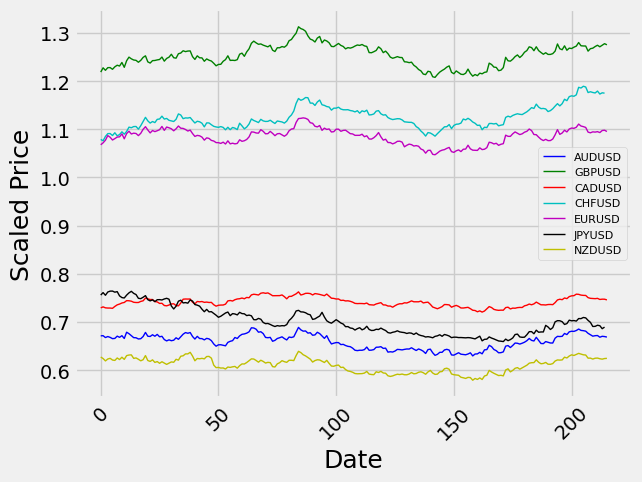

In [26]:
cycol = cycle('bgrcmky')
price_data = pd.DataFrame()
for symbol in SYMBOLS:
    multiplier = 1.0
    if symbol == 'JPYUSD':
        multiplier = 100.0
    label = symbol
    price_data = price_data.assign(label=pd.Series(symbols_data[symbol]['Close'] * multiplier, index=symbols_data[symbol].index))
    ax = price_data['label'].plot(color=next(cycol), lw=1., label=label)
plt.xlabel('Date', fontsize=18)
plt.xticks(rotation=45)
plt.ylabel('Scaled Price', fontsize=18)
plt.legend(prop={'size': 8})
plt.show()

In [31]:
import statistics as stats

TRADING_INSTRUMENT = 'EURUSD'

# Constants/variables that are used to compute simple moving average and price deviation from simple moving average
SMA_NUM_PERIODS = 20  # look back period
price_history = {}  # history of prices

PRICE_DEV_NUM_PRICES = 200 # look back period of ClosePrice deviations from SMA
price_deviation_from_sma = {}  # history of ClosePrice deviations from SMA

# We will use this to iterate over all the days of data we have
num_days = len(symbols_data[TRADING_INSTRUMENT].index)
correlation_history = {} # history of correlations per currency pair
delta_projected_actual_history = {} # history of differences between Projected ClosePrice deviation and actual ClosePrice deviation per currency pair

final_delta_projected_history = [] # history of differences between final Projected ClosePrice deviation for TRADING_INSTRUMENT and actual ClosePrice deviation

# Variables for Trading Strategy trade, position & pnl management:
orders = []  # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = []  # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = []  # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0  # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0  # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0  # Current position of the trading strategy
buy_sum_price_qty = 0  # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0  # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0  # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0  # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0  # Open/Unrealized PnL marked to market
closed_pnl = 0  # Closed/Realized PnL so far

# Constants that define strategy behavior/thresholds
StatArb_VALUE_FOR_BUY_ENTRY = 0.01  # StatArb trading signal value aboe which to enter buy-orders/long-position
StatArb_VALUE_FOR_SELL_ENTRY = -0.01  # StatArb trading signal value below which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 0.01  # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 1000000  # Number of currency to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10  # Minimum Open/Unrealized profit at which to close positions and lock profits

for i in range(0, num_days):
  close_prices = {}

  # Build ClosePrice series, compute SMA for each symbol and price-deviation from SMA for each symbol
  for symbol in SYMBOLS:
    close_prices[symbol] = symbols_data[symbol]['Close']
    if not symbol in price_history.keys():
      price_history[symbol] = []
      price_deviation_from_sma[symbol] = []

    price_history[symbol].append(close_prices[symbol])
    if len(price_history[symbol]) > SMA_NUM_PERIODS:  # we track at most SMA_NUM_PERIODS number of prices
      del (price_history[symbol][0])

    sma = stats.mean(price_history[symbol]) # Rolling SimpleMovingAverage
    price_deviation_from_sma[symbol].append(close_prices[symbol] - sma) # price deviation from mean
    if len(price_deviation_from_sma[symbol]) > PRICE_DEV_NUM_PRICES:
      del (price_deviation_from_sma[symbol][0])

  # Now compute covariance and correlation between TRADING_INSTRUMENT and every other lead symbol
  # also compute projected price deviation and find delta between projected and actual price deviations.
  projected_dev_from_sma_using = {}
  for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:  # no need to find relationship between trading instrument and itself
      continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol
    if correlation_label not in correlation_history.keys(): # first entry for this pair in the history dictionary
      correlation_history[correlation_label] = []
      delta_projected_actual_history[correlation_label] = []

    if len(price_deviation_from_sma[symbol]) < 2: # need atleast two observations to compute covariance/correlation
      correlation_history[correlation_label].append(0)
      delta_projected_actual_history[correlation_label].append(0)
      continue

    corr = np.corrcoef(price_deviation_from_sma[TRADING_INSTRUMENT], price_deviation_from_sma[symbol])
    cov = np.cov(price_deviation_from_sma[TRADING_INSTRUMENT], price_deviation_from_sma[symbol])
    corr_trading_instrument_lead_instrument = corr[0, 1]  # get the correlation between the 2 series
    cov_trading_instrument_lead_instrument = cov[0, 0] / cov[0, 1] # get the covariance between the 2 series

    correlation_history[correlation_label].append(corr_trading_instrument_lead_instrument)

    # projected-price-deviation-in-TRADING_INSTRUMENT is covariance * price-deviation-in-lead-symbol
    projected_dev_from_sma_using[symbol] = price_deviation_from_sma[symbol][-1] * cov_trading_instrument_lead_instrument

    # delta +ve => signal says TRADING_INSTRUMENT price should have moved up more than what it did
    # delta -ve => signal says TRADING_INSTRUMENT price should have moved down more than what it did.
    delta_projected_actual = (projected_dev_from_sma_using[symbol] - price_deviation_from_sma[TRADING_INSTRUMENT][-1])
    delta_projected_actual_history[correlation_label].append(delta_projected_actual)

  # weigh predictions from each pair, weight is the correlation between those pairs
  sum_weights = 0 # sum of weights is sum of correlations for each symbol with TRADING_INSTRUMENT
  for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:  # no need to find relationship between trading instrument and itself
      continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol
    sum_weights += abs(correlation_history[correlation_label][-1])

  final_delta_projected = 0 # will hold final prediction of price deviation in TRADING_INSTRUMENT, weighing projections from all other symbols.
  close_price = close_prices[TRADING_INSTRUMENT]
  for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:  # no need to find relationship between trading instrument and itself
      continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol

    # weight projection from a symbol by correlation
    final_delta_projected += (abs(correlation_history[correlation_label][-1]) * delta_projected_actual_history[correlation_label][-1])

  # normalize by diving by sum of weights for all pairs
  if sum_weights != 0:
    final_delta_projected /= sum_weights
  else:
    final_delta_projected = 0

  final_delta_projected_history.append(final_delta_projected)

TypeError: can't convert type 'Series' to numerator/denominator